## In-situ reflectometry notebook

 In order to make the code more versatile and useful for a wider range of applications, we have implemented the vannila version of in-situ reflectometry and provided its description in the repository, providing a separate example file. For the time being we have not included description of this mechanism in the manuscript, as the corresponding user interface is likely to change, once barrier gates are added (work in progress). Nevertheless, below we provide a brief description of the implemented feature from the corresponding notebook example ```insitu_reflectometry.ipynb```:

Following Vigneau et al. (2023), we have implemented the adiabatic version of the quantum capacitance sensing. We use the fact that capacitance is proportional to $\partial P_\mathbf{n}/\partial \epsilon$, where $P_\mathbf{n}$ is the probability of finding charge occupation $\mathbf{n}$ that minimizes electrostatic energy $E_\mathbf{n}$ at given voltage $\mathbf{v}$, and $\epsilon_{\mathbf{n}\mathbf{m}}$ is the energy detuning to the next energy state with charge configuration $\mathbf{m}$. The insitu signal is activated by adding the insitu_axis argument (default: None):
```python

model = CapacitanceModel(
    ...
    insitu_axis=[1,0],
    plane_axes=[[1,0],[0,1]]
    ...
)
```
where by defining the vector ```insitu_axis``` we select which gate is to be modulated. In the example above, the oscilattory signal is coupled to the first axis, which according to ```insitu_axis``` is corresponds to the first plunger gate $v_0$. We compute the relative signal strenght using finite difference approximation to the derrivative:
$$
S(\mathbf v) \propto  \frac{\partial P_\mathbf{n}}{\partial \epsilon_{\mathbf{n}\mathbf{m}}} \approx \frac{P_\mathbf{n}(\mathbf v + \delta \mathbf v) - P_\mathbf{n}(\mathbf v)}{\epsilon_{\mathbf{n}\mathbf{m}}(\mathbf{v} + \delta \mathbf v)- \epsilon_{\mathbf{n}\mathbf{m}}(\mathbf{v})}
$$
where $\delta \mathbf v = \delta v$ (```insitu_axis```$\cdot$ ```plane_axes```), $e\alpha$ is a constant irrelevant for normalized signal, and we keep $\delta v = 0.01$mV is sufficiently small and fixed. 

To compute the signal $S(\mathbf{v})$ at every point in voltage space we contruct two-level Hamiltonian, using the subspace of two lowest lying energy states,
$$
H_{2\text{-level}}(\mathbf{v}) = \begin{pmatrix}
E(\mathbf{n},\mathbf{v}) & t_{\mathbf{n}\mathbf{m}}(\mathbf{v}) \\
t_{\mathbf{n}\mathbf{m}}(\mathbf{v}) & E(\mathbf{m},\mathbf{v})
\end{pmatrix}
$$
where $E(\mathbf{n},\mathbf{v})$ and $E(\mathbf{m},\mathbf{v})$ are the ground and excited state electrostatic energies corresponding to charge occupation $\mathbf{n}$ and $\mathbf{m}$, and $t_{\mathbf{n}\mathbf{m}}$ is the tunnel coupling between them, which is either constant or zero if two states are not coupled. Using the Hamiltonian one can compute relevant quantities, such as the energy detuning $\epsilon_{\mathbf{n}\mathbf{m}}(\mathbf{v})=E(\mathbf{n},\mathbf{v})-E(\mathbf{m},\mathbf{v})$ and the probability of being in on of the charge configurations 
$$
P_\mathbf{n}(\mathbf{v}) = \frac{1}{2} \left(1 - \frac{\epsilon_{\mathbf{n}\mathbf{m}}(\mathbf{v})}{\sqrt{\epsilon_{\mathbf{n}\mathbf{m}}(\mathbf{v})^2 + 4t_{\mathbf{n}\mathbf{m}}^2(\mathbf{v})}}\right)
$$
Intuitively we assume the signal is proportional to the change in quantum capacitance, caused by motion of the electron between the dots induced by the modulation of the gate voltages. At this point, we have not included the other effects contributing to in-situ signal including sisyphus resistance and tunneling capacitance, however their contribution is expected to be relatively weaker [Vigneau et al. (2023)].

Below we are attaching the notebook reconstructing the in-situ signal for three dot system.


In [1]:
# add Code folder
import sys
sys.path.append('../src')


# import main class and plotting function
from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

#reload file


# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Define the system

#All capacitances are given in aF
N = 3 #number of dots   
C_DD=20* np.eye((N))/2 #The self-capacitance of each dot, NOTE: factor of 2 due to symmetrization
C_DD[0,1] = 4 
C_DD[0,2] = 2 
C_DD[1,2] = 3
C_DD = C_DD + C_DD.T #symmetrize

C_DG=4*np.eye(N) #dot-to-gate capacitances 
C_DG[0,1] = 0.7
C_DG[1,2] = 0.6
C_DG[0,2] = 0.5


# NOTE: we use the convention that tc is the energy gap at avoided crossing H = tc/2 sx
tunnel_couplings = np.zeros((N,N))
tunnel_couplings[0,1] = 50*1e-6
tunnel_couplings[1,2] = 50*1e-6
tunnel_couplings[0,2] = 50*1e-6
tunnel_couplings = tunnel_couplings + tunnel_couplings.T

In [3]:
capacitance_config = {
        "C_DD" : C_DD,  #dot-dot capacitance matrix
        "C_Dg" : C_DG,  #dot-gate capacitance matrix
        "ks" : None       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
}

tunneling_config = {
        "tunnel_couplings": tunnel_couplings, #tunnel coupling matrix
        "temperature": 0.1,                   #temperature in Kelvin
        "energy_range_factor": 5,  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
}
sensor_config = {
        "sensor_dot_indices": [],  #Indices of the sensor dots
        "sensor_detunings": [],  #Detuning of the sensor dots
        "noise_amplitude": {"fast_noise": 0.8*1e-6, "slow_noise": 1e-8}, #Noise amplitude for the sensor dots in eV
        "peak_width_multiplier": 15,  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
}


In [4]:
experiment = Experiment(capacitance_config, tunneling_config, sensor_config)

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[20.  4.  2.]
 [ 4. 20.  3.]
 [ 2.  3. 20.]]
                Dot-gate capacitances: 
                [[4.  0.7 0.5]
 [0.  4.  0.6]
 [0.  0.  4. ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: []
            Sensor detunings: [] meV
            Coulomb peak width: 0.41 meV
            Slow noise amplitude: 0.01 ueV
            Fast noise amplitude: 0.8 ueV
            Signal noise scale: 0.0
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 5.e-05 5.e-05]
 [5.e-05 0.e+00 5.e-05]
 [5.e-05 5.e-05 0.e+00]]
            Temperature: 0.1 K
            Energy range factor: 5
            


In [5]:
#Show the same transition with gate virtualisation
xV, yV, csd_dataV, polytopesV, sensors ,_ = experiment.generate_CSD(
            x_voltages = np.linspace(-0.02, 0.05, 200),  #V
            y_voltages = np.linspace(-0.02, 0.05, 200),  #V
            plane_axes = [[1,0,0],[0,0,1]], #we use v0, v1
            target_transition = [-1,1,0],   #we target at the [1,1,0] -> [0,2,0] transition
            target_state = [1,1,0],
            compute_polytopes =  True,                  
            use_virtual_gates= False,
            use_sensor_signal = True, #this has to be active to allow for insitu_axis
            insitu_axis = [1,0])  #in_situ reflectometry is activated when insitu_axis is not None it is a vector in the basis of plane_axes


v_offset found: [ 0.13350857  0.27012592 -0.82873128]


In [15]:
sensors

array([], shape=(200, 200, 0), dtype=float64)

Text(0, 0.5, '$v_1$ (V)')

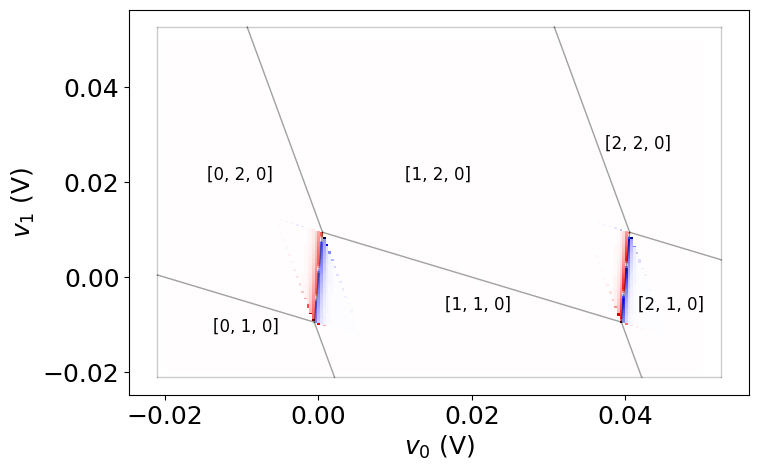

In [6]:
#plot
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.pcolormesh(xV, yV, sensors[:,:,0], cmap = "seismic", vmin=-0.5, vmax=0.5)   
plot_polytopes(ax, polytopesV, axes_rescale=1, fontsize = 12, alpha = 0.2, color="k")
plt.xlabel("$v_0$ (V)")
plt.ylabel("$v_1$ (V)")
